# London weather analysis

In [4]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib.rcParams['figure.dpi']= 100
matplotlib.rcParams['figure.figsize'] = 15, 5


import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm

In [5]:
# read processed before dataset
df = pd.read_csv("London.csv", index_col=0)
df.set_index([pd.to_datetime(df.index)], inplace=True)

In [6]:
df

,TEMP,DEWP,VISIB,WDSP,PRCP
1990-01-01,43.031222,38.491931,11.417382,11.254774,63.821907
1990-01-08,43.056439,38.555876,6.461101,11.913353,61.499831
1990-01-15,43.016749,38.731034,11.217734,10.875369,64.033005
1990-01-22,43.135345,38.474156,6.228783,11.063916,58.931474
1990-02-01,43.112913,38.332108,6.351513,11.301232,63.628401
...,...,...,...,...,...
2019-10-22,46.757143,42.357143,6.185714,10.514286,85.705714
2019-11-01,48.614286,46.014286,6.000000,6.914286,85.705714
2019-11-08,42.614286,38.542857,6.042857,9.728571,85.705714
2019-11-15,39.575000,37.125000,6.150000,5.175000,49.995000


Our weather data contains measures of temperature, dew point, visibility, wind speed and precipitation amount. Here I will analyse each of this measurment.

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

# decompose time series data to trend, season and residuals
def decompose(ts, freq):
    decomposition = seasonal_decompose(ts, freq=freq)

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    residual.dropna(inplace=True);
    
    # Original
    plt.subplot(411)
    plt.plot(ts, label='Original')
    plt.legend(loc='upper left')
    
    # Trend
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='upper left')
    
    # Seasonality
    plt.subplot(413)
    plt.plot(seasonal, label='Seasonality')
    plt.legend(loc='upper left')
    
    # Resudials
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='upper left')
    
    plt.tight_layout()
    return (residual, trend, seasonal)

## Temperature

In [10]:
temp = df.TEMP
temp

1990-01-01    43.031222
1990-01-08    43.056439
1990-01-15    43.016749
1990-01-22    43.135345
1990-02-01    43.112913
                ...    
2019-10-22    46.757143
2019-11-01    48.614286
2019-11-08    42.614286
2019-11-15    39.575000
2019-11-22    45.342347
Name: TEMP, Length: 1436, dtype: float64


To predict weather data for 2019 year, we will use ARIMA model.To do that we need to decompose data to make our time series data stationary - extract trend and season from it.


__Decomposing__

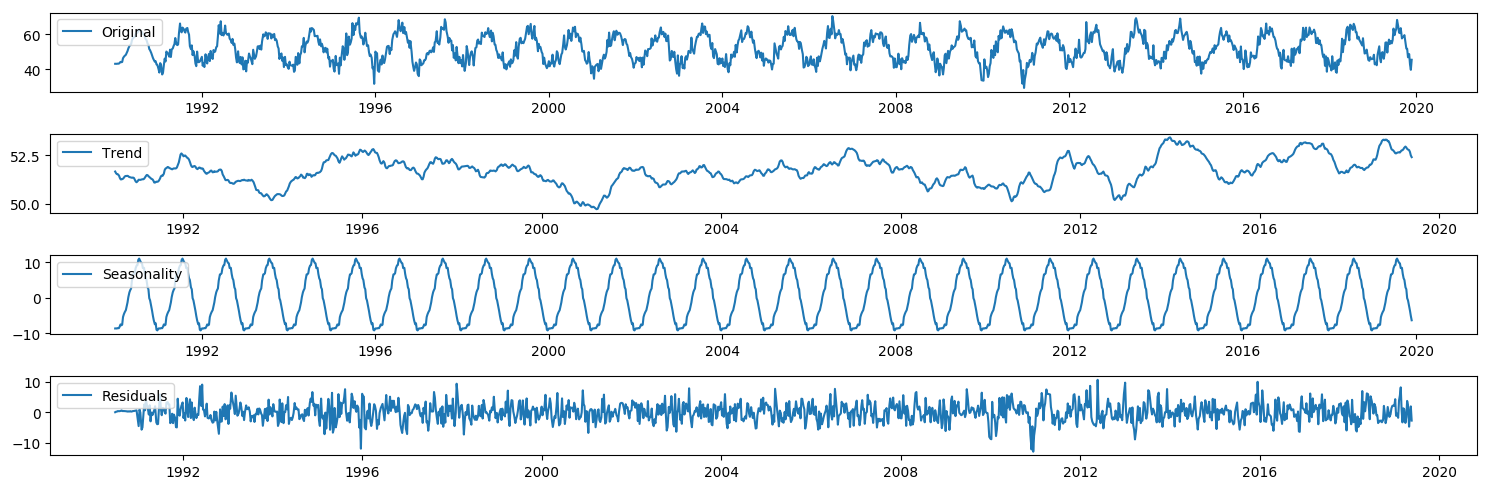

In [11]:
# 48, cause there are 4 weeks for each month, and there are 12 month, so period should be 4*12 = 48
temp_results = decompose(temp, 48)
temp_res = temp_results[0]

In [12]:
temp_res

1990-07-01   -0.022127
1990-07-08    0.135424
1990-07-15    0.179028
1990-07-22    0.345191
1990-08-01    0.313045
                ...   
2019-04-22    2.403563
2019-05-01   -4.770279
2019-05-08   -0.237039
2019-05-15    1.890525
2019-05-22   -2.774654
Name: TEMP, Length: 1388, dtype: float64

Now, lets check stationarity of our residuals. To do that, I'll use ADF test. To be 99% confident, that ts is stationary, ADF statistic should be less than critical value of 1%. Also we can check stationarity be p-value - it should be less than 0.01.

In [13]:
from statsmodels.tsa.stattools import adfuller

def df_test(ts):
    result = adfuller(ts)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [14]:
df_test(temp_res)

ADF Statistic: -12.817515
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


__Selecting parameters of the model__

As we can see, our residuals are stationary, do now we can use ARIMA. ARIMA has 3 parameters: __p, d and  q__. __d__ responds for differencing level(another way to make ts stationary), but, as we already did our data stationary, we can set d=0 to not difference our ts one more time. Now, lets find p and q.

To find p I'll use partial autocorrelation function (PACF), and to find q - autocorrelation function (ACF). We need to take first biggest lag, which is above significance line. 

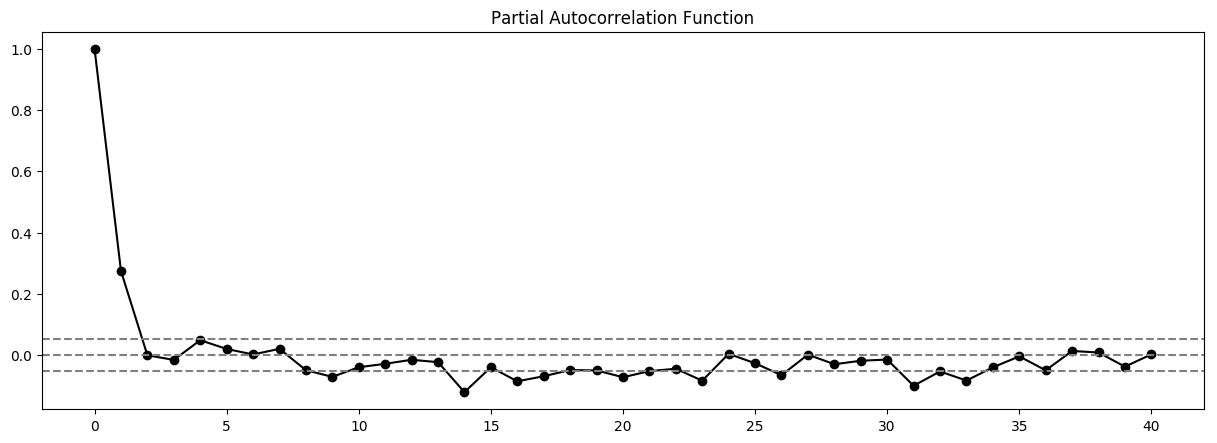

In [15]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

lag_pacf = pacf(temp_res, nlags=40)

#Plot PACF: 
plt.plot(lag_pacf, 'ok-')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(temp_res)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(temp_res)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function');

So, here first biggest lag above signifacance line is 1, so __p=1__.

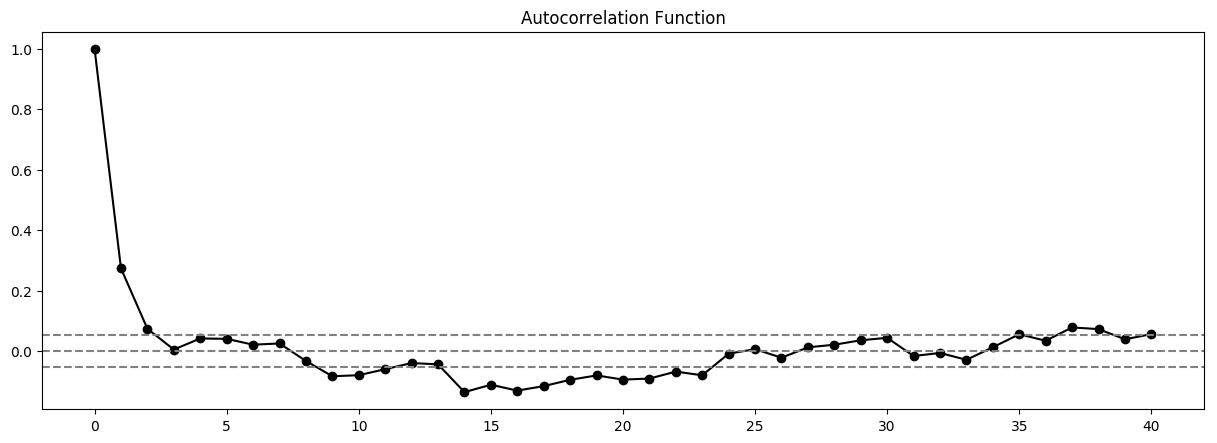

In [16]:
lag_acf = acf(temp_res, nlags=40)

#Plot ACF: 
plt.plot(lag_acf, 'ok-')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(temp_res)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(temp_res)),linestyle='--',color='gray')
plt.title('Autocorrelation Function');

Here, __q=2__

__Fitting model and predicting__

In [17]:
temp_model = ARIMA(temp_res, order=(1, 0, 2))
temp_model_fit = temp_model.fit(disp=-1)

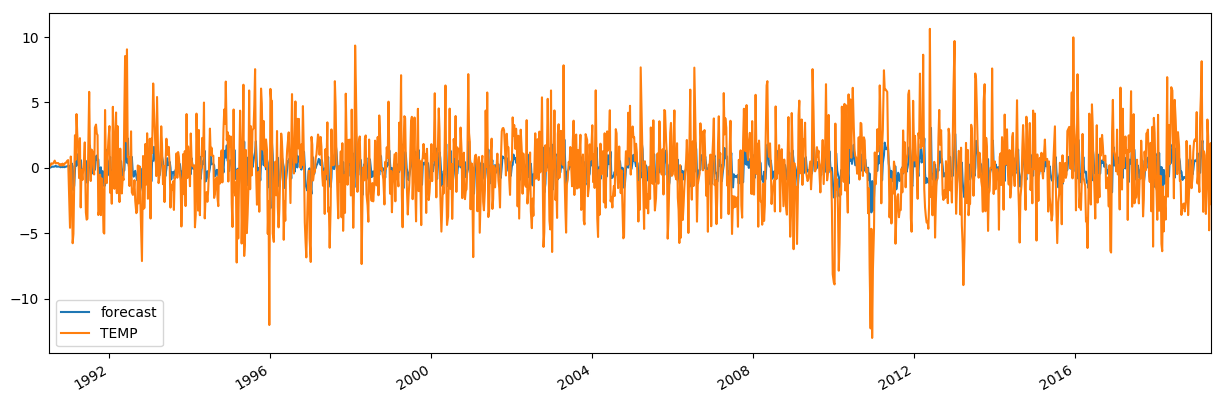

In [18]:
# Actual vs Fitted
temp_model_fit.plot_predict(dynamic=False)
plt.show()

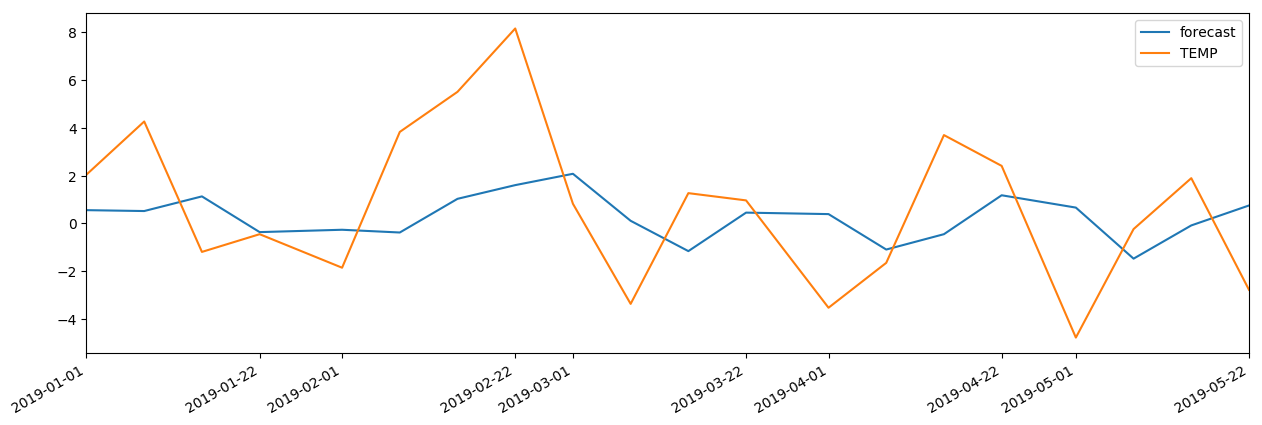

In [19]:
# only 2019 year
temp_model_fit.plot_predict(start="2019-01-01"  ,dynamic=False)
plt.show()

## Dew point

In [20]:
dewp = df.DEWP
dewp

1990-01-01    38.491931
1990-01-08    38.555876
1990-01-15    38.731034
1990-01-22    38.474156
1990-02-01    38.332108
                ...    
2019-10-22    42.357143
2019-11-01    46.014286
2019-11-08    38.542857
2019-11-15    37.125000
2019-11-22    41.171183
Name: DEWP, Length: 1436, dtype: float64

__Decomposing__

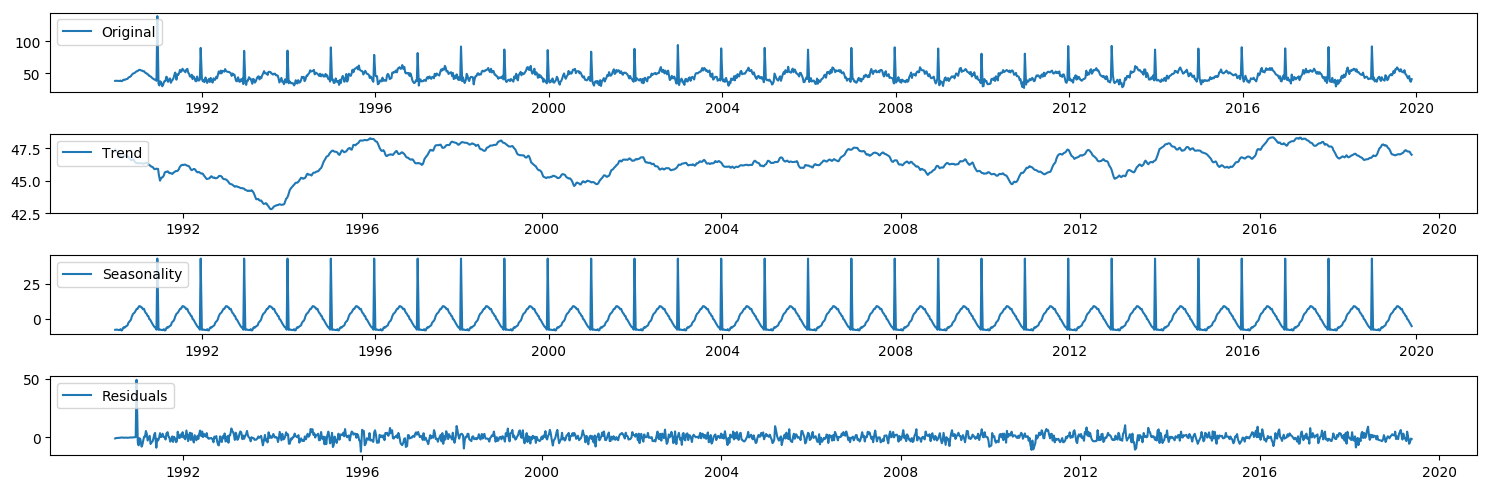

In [21]:
dewp_results = decompose(dewp, 48)
dewp_res = dewp_results[0]

In [22]:
dewp_res

1990-07-01   -1.075565
1990-07-08   -0.760218
1990-07-15   -0.717793
1990-07-22   -0.619816
1990-08-01   -0.594536
                ...   
2019-04-22    1.159049
2019-05-01   -5.646088
2019-05-08   -4.610953
2019-05-15   -1.183545
2019-05-22   -1.589990
Name: DEWP, Length: 1388, dtype: float64

In [23]:
df_test(dewp_res)

ADF Statistic: -13.580854
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


Residuals for dew point is stationary now, so we can select parameters for model.

__Selecting parameters of the model__

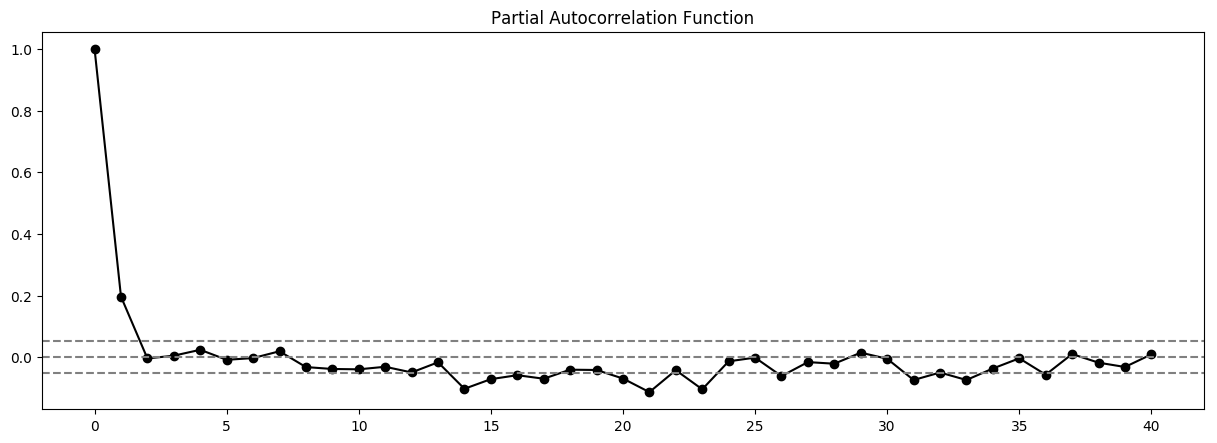

In [24]:
lag_pacf = pacf(dewp_res, nlags=40)

#Plot PACF: 
plt.plot(lag_pacf, 'ok-')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dewp_res)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(dewp_res)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function');

So, __p=1__.

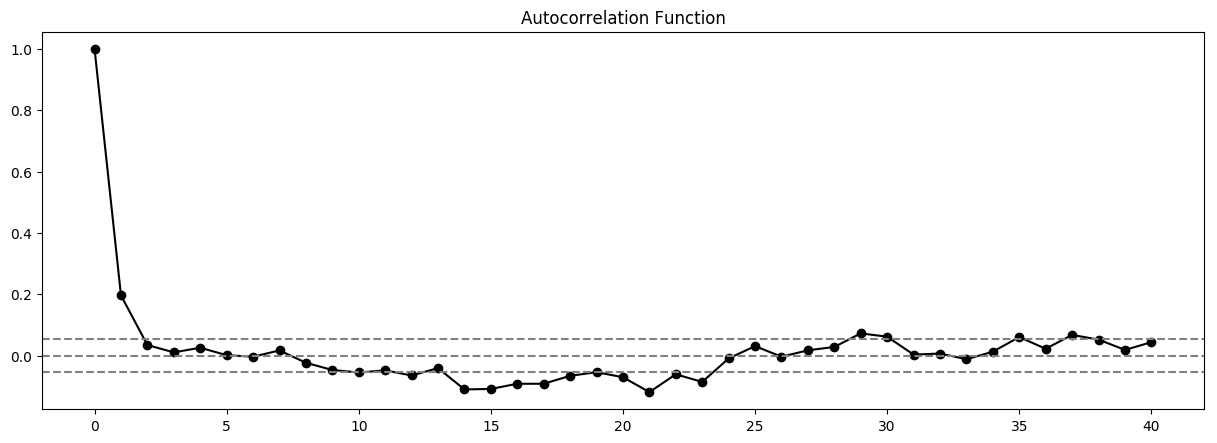

In [25]:
lag_acf = acf(dewp_res, nlags=40)

#Plot ACF: 
plt.plot(lag_acf, 'ok-')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dewp_res)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(dewp_res)),linestyle='--',color='gray')
plt.title('Autocorrelation Function');

__q=1__

__Fitting model and predicting__

In [26]:
dewp_model = ARIMA(dewp_res, order=(1, 0, 1))
dewp_model_fit = dewp_model.fit(disp=-1)

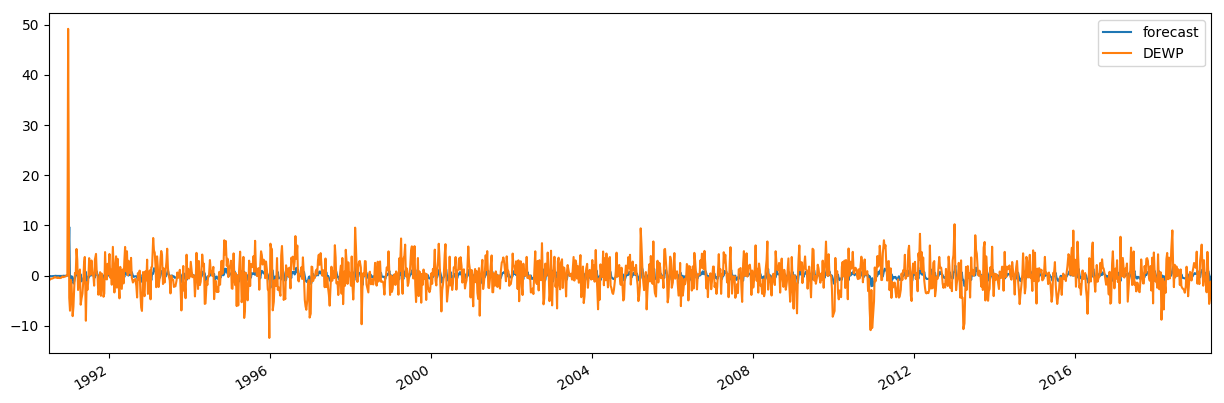

In [27]:
# Actual vs Fitted
dewp_model_fit.plot_predict(dynamic=False)
plt.show()

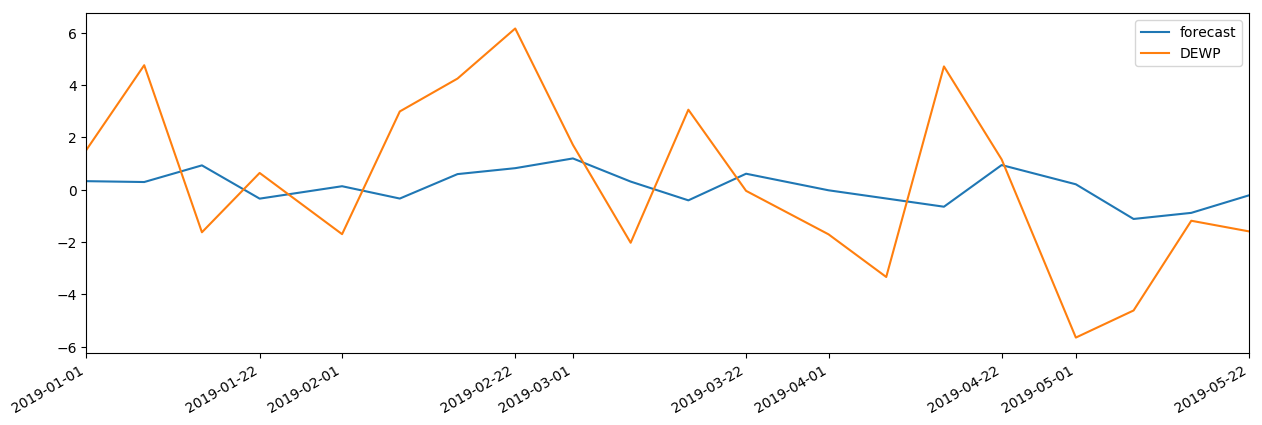

In [28]:
# only 2019 year
dewp_model_fit.plot_predict(start="2019-01-01"  ,dynamic=False)
plt.show()

## Visibility

In [29]:
visib = df.VISIB
visib

1990-01-01    11.417382
1990-01-08     6.461101
1990-01-15    11.217734
1990-01-22     6.228783
1990-02-01     6.351513
                ...    
2019-10-22     6.185714
2019-11-01     6.000000
2019-11-08     6.042857
2019-11-15     6.150000
2019-11-22     6.413757
Name: VISIB, Length: 1436, dtype: float64

__Decomposing__

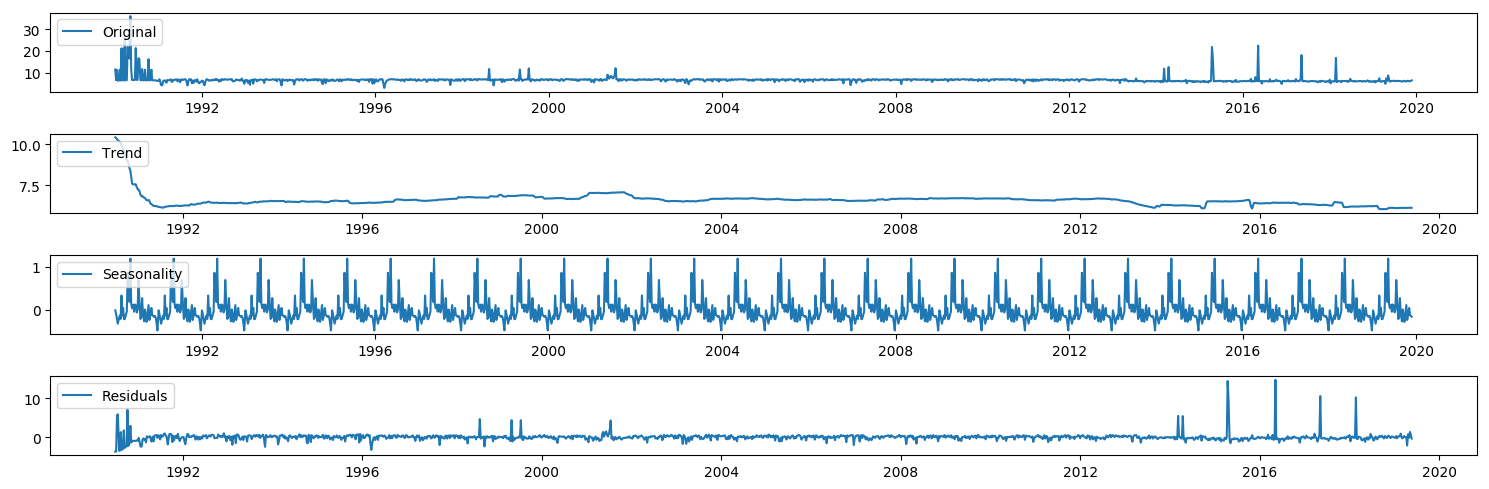

In [31]:
visib_results = decompose(visib, 48)
visib_res = visib_results[0]

In [32]:
visib_res

1990-07-01   -3.757180
1990-07-08   -3.719631
1990-07-15    5.576408
1990-07-22    5.860412
1990-08-01   -3.535335
                ...   
2019-04-22    0.725994
2019-05-01   -0.171023
2019-05-08    1.337003
2019-05-15    0.559103
2019-05-22   -0.367315
Name: VISIB, Length: 1388, dtype: float64

In [33]:
df_test(visib_res)

ADF Statistic: -28.019867
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


Visibility data is stationary

__Selecting parameters of the model__

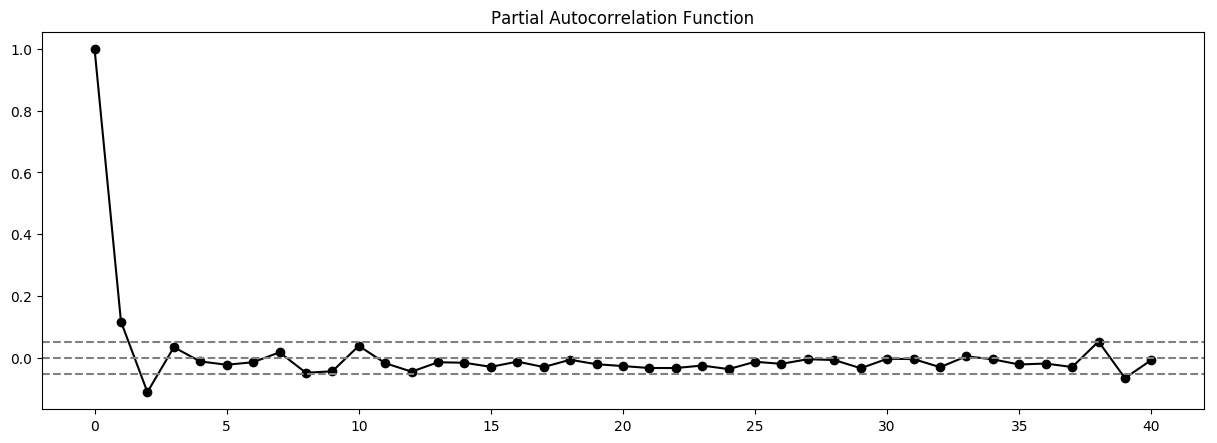

In [34]:
lag_pacf = pacf(visib_res, nlags=40)

#Plot PACF: 
plt.plot(lag_pacf, 'ok-')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(visib_res)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(visib_res)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function');

__p=1__

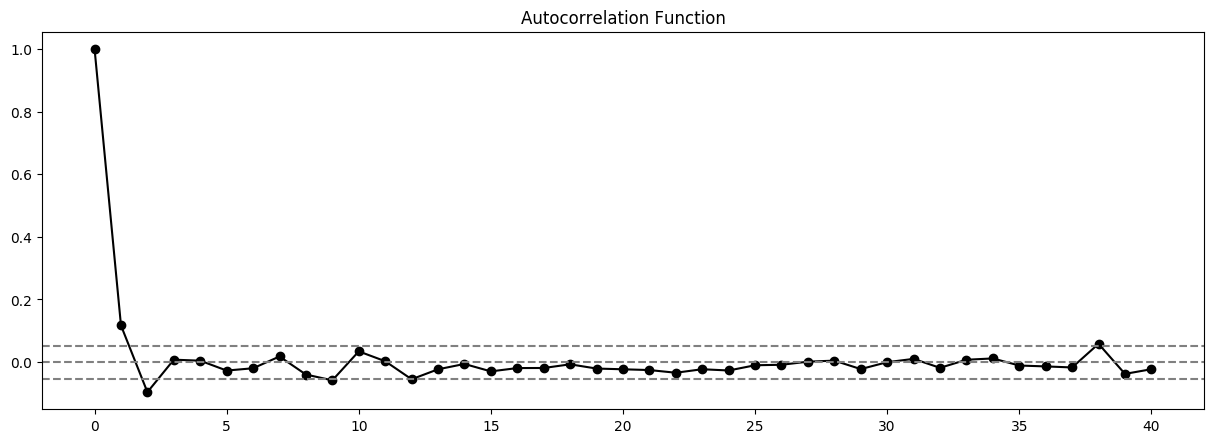

In [35]:
lag_acf = acf(visib_res, nlags=40)

#Plot ACF: 
plt.plot(lag_acf, 'ok-')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(visib_res)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(visib_res)),linestyle='--',color='gray')
plt.title('Autocorrelation Function');

__q=1__

__Fitting model and predicting__

In [36]:
visib_model = ARIMA(visib_res, order=(1, 0, 1))
visib_model_fit = visib_model.fit(disp=-1)

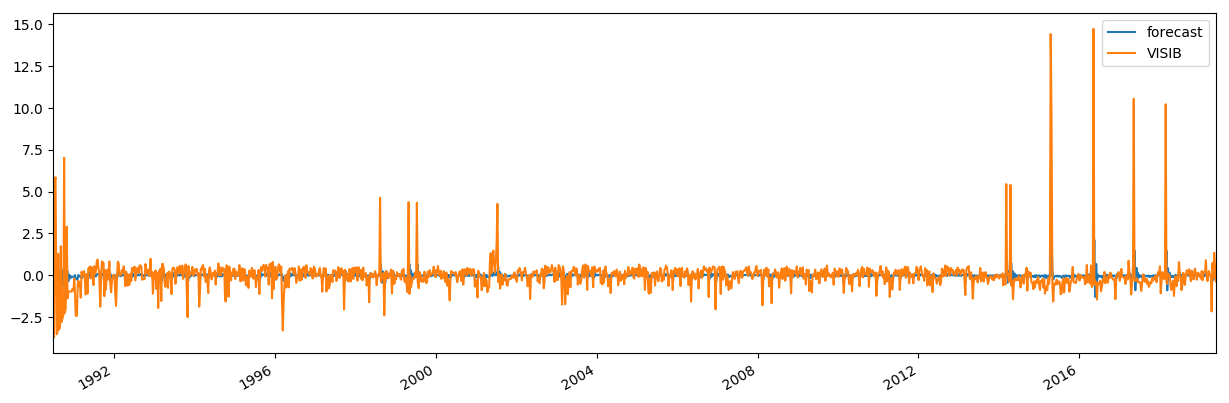

In [37]:
# Actual vs Fitted
visib_model_fit.plot_predict(dynamic=False)
plt.show()

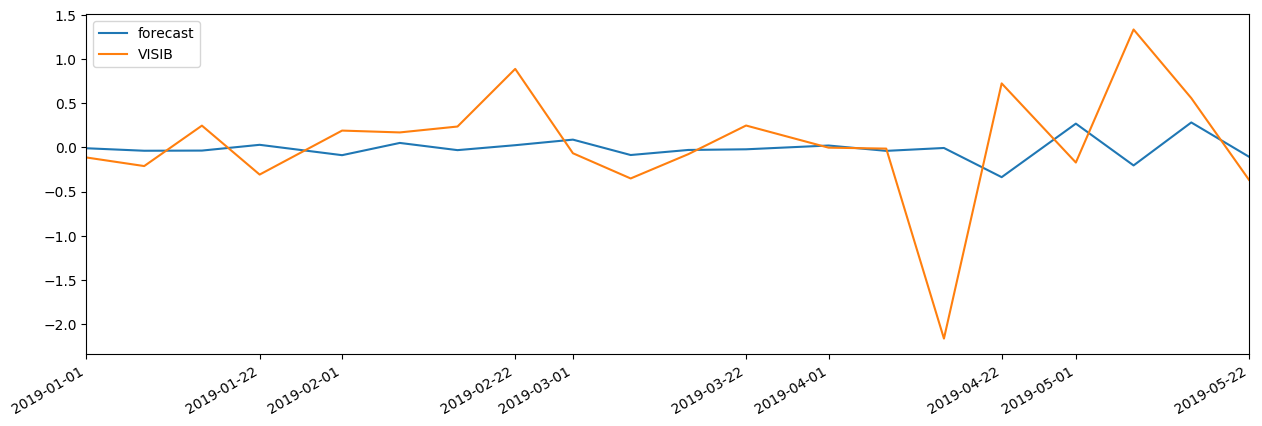

In [38]:
# only 2019 year
visib_model_fit.plot_predict(start="2019-01-01"  ,dynamic=False)
plt.show()

## Wind speed

In [39]:
wdsp = df.WDSP
wdsp

1990-01-01    11.254774
1990-01-08    11.913353
1990-01-15    10.875369
1990-01-22    11.063916
1990-02-01    11.301232
                ...    
2019-10-22    10.514286
2019-11-01     6.914286
2019-11-08     9.728571
2019-11-15     5.175000
2019-11-22    10.428666
Name: WDSP, Length: 1436, dtype: float64

__Decomposition__

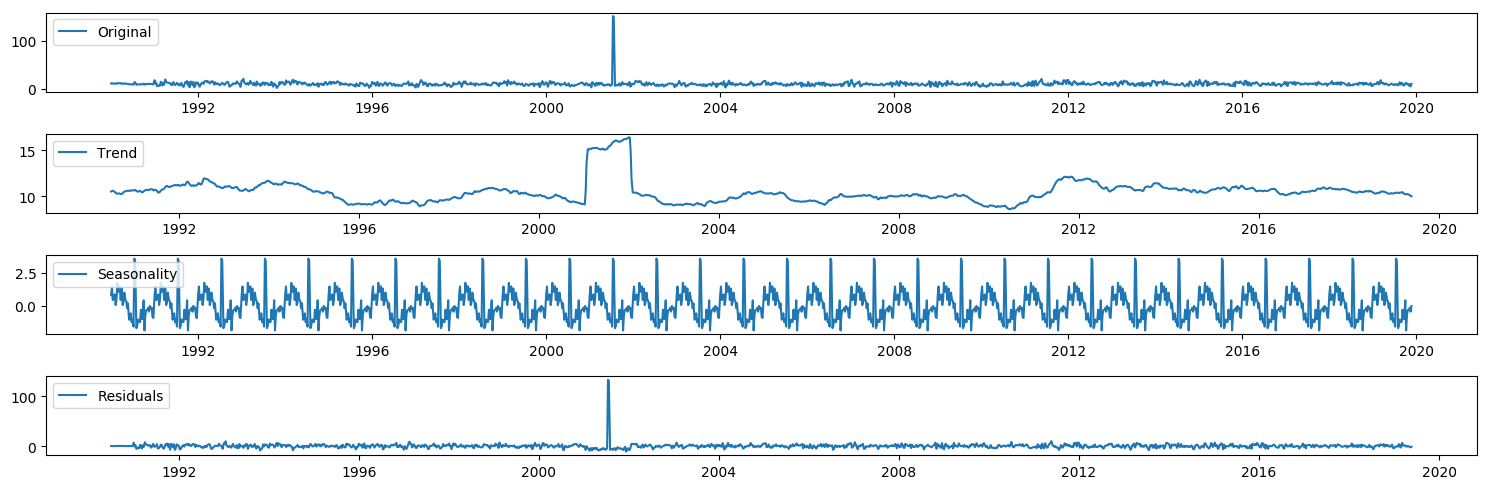

In [40]:
wdsp_results = decompose(wdsp, 48)
wdsp_res = wdsp_results[0]

In [41]:
wdsp_res

1990-07-01   -0.060344
1990-07-08   -0.152708
1990-07-15   -0.304103
1990-07-22   -0.228202
1990-08-01   -0.049513
                ...   
2019-04-22    0.128867
2019-05-01   -1.053814
2019-05-08   -1.872074
2019-05-15   -2.611586
2019-05-22   -1.431835
Name: WDSP, Length: 1388, dtype: float64

In [42]:
df_test(wdsp_res)

ADF Statistic: -12.396292
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


Wind speed data is stationary now

__Selecting parameters of the model__

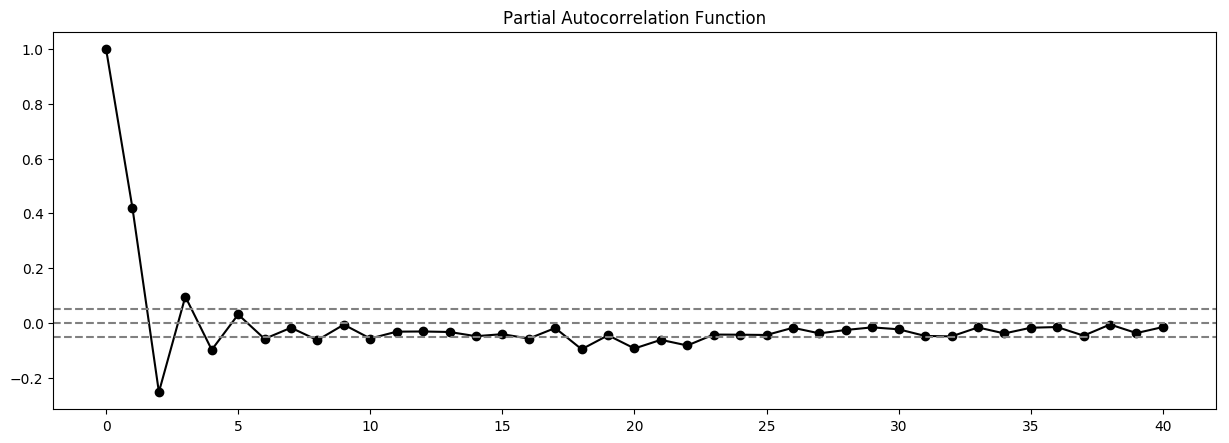

In [43]:
lag_pacf = pacf(wdsp_res, nlags=40)

#Plot PACF: 
plt.plot(lag_pacf, 'ok-')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(wdsp_res)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(wdsp_res)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function');

__p=1__

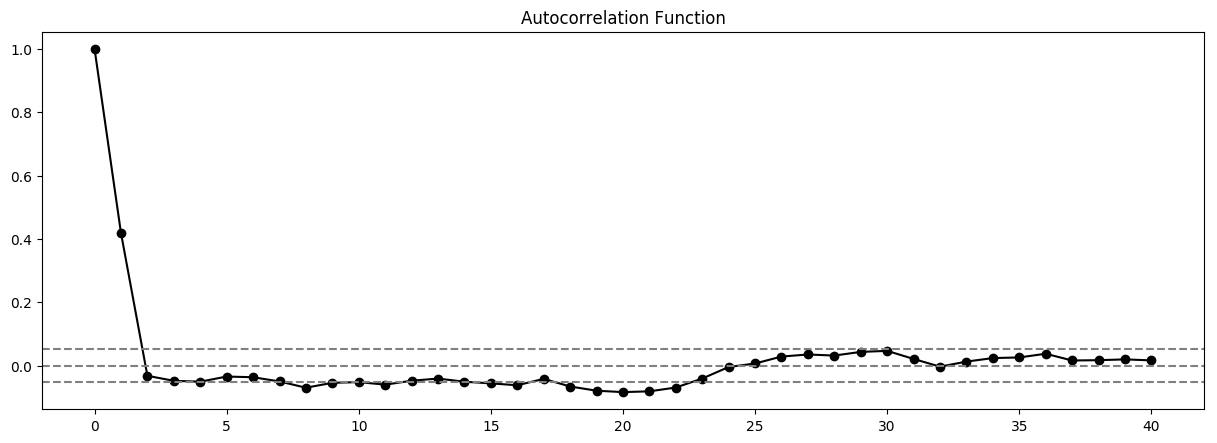

In [44]:
lag_acf = acf(wdsp_res, nlags=40)

#Plot ACF: 
plt.plot(lag_acf, 'ok-')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(wdsp_res)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(wdsp_res)),linestyle='--',color='gray')
plt.title('Autocorrelation Function');

__q=1__

__Fitting model and predicting__

In [45]:
wdsp_model = ARIMA(wdsp_res, order=(1, 0, 1))
wdsp_model_fit = wdsp_model.fit(disp=-1)

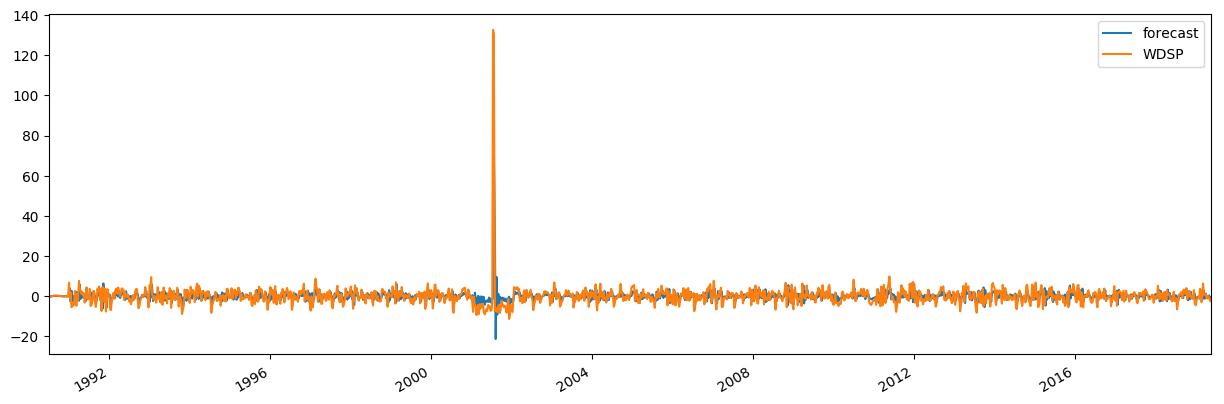

In [46]:
# Actual vs Fitted
wdsp_model_fit.plot_predict(dynamic=False)
plt.show()

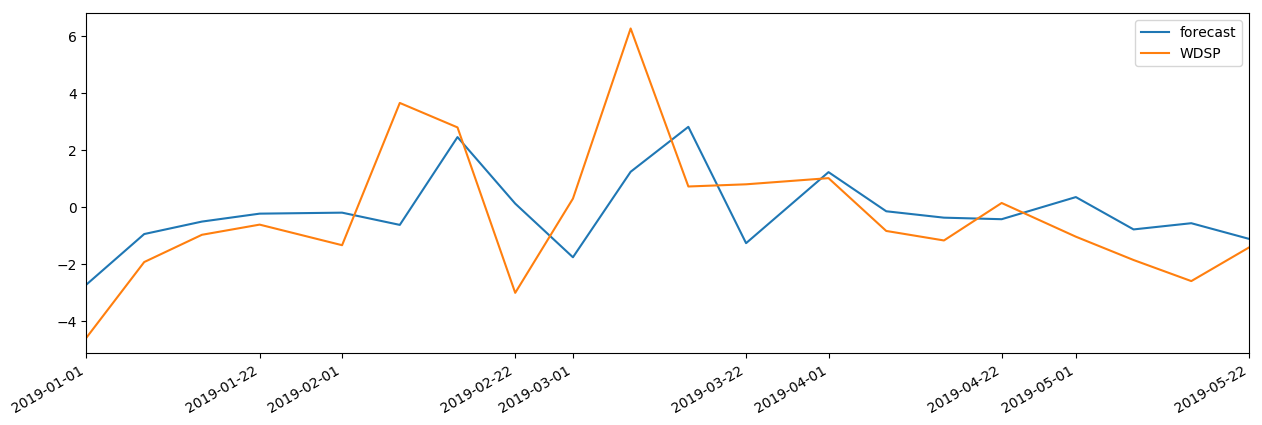

In [47]:
# only 2019 year
wdsp_model_fit.plot_predict(start="2019-01-01"  ,dynamic=False)
plt.show()

## Precipitation amount

In [48]:
prcp = df.PRCP
prcp

1990-01-01    63.821907
1990-01-08    61.499831
1990-01-15    64.033005
1990-01-22    58.931474
1990-02-01    63.628401
                ...    
2019-10-22    85.705714
2019-11-01    85.705714
2019-11-08    85.705714
2019-11-15    49.995000
2019-11-22    59.933537
Name: PRCP, Length: 1436, dtype: float64

__Decomposition__

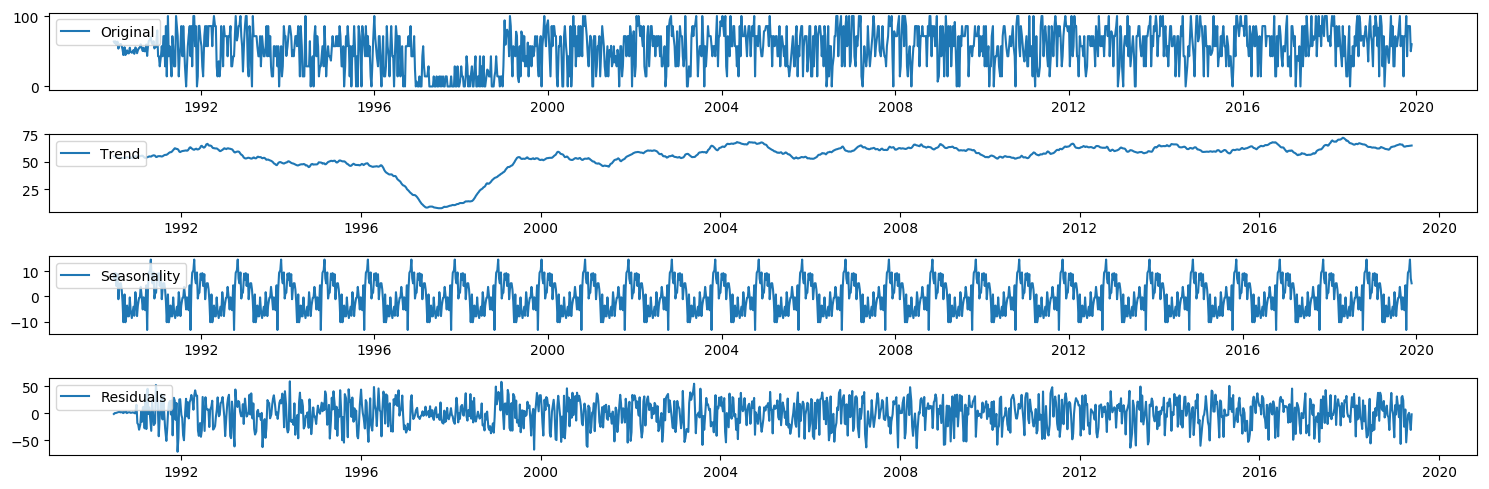

In [49]:
prcp_results = decompose(prcp, 48)
prcp_res = prcp_results[0]

In [50]:
prcp_res

1990-07-01    -1.440883
1990-07-08     0.130219
1990-07-15     0.280429
1990-07-22     0.694612
1990-08-01     1.623650
                ...    
2019-04-22    -3.465327
2019-05-01     0.675907
2019-05-08   -13.779541
2019-05-15   -30.845711
2019-05-22    -2.125034
Name: PRCP, Length: 1388, dtype: float64

In [51]:
df_test(prcp_res)

ADF Statistic: -12.215127
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


Percipitations are also stationary

__Selecting parameters of the model__

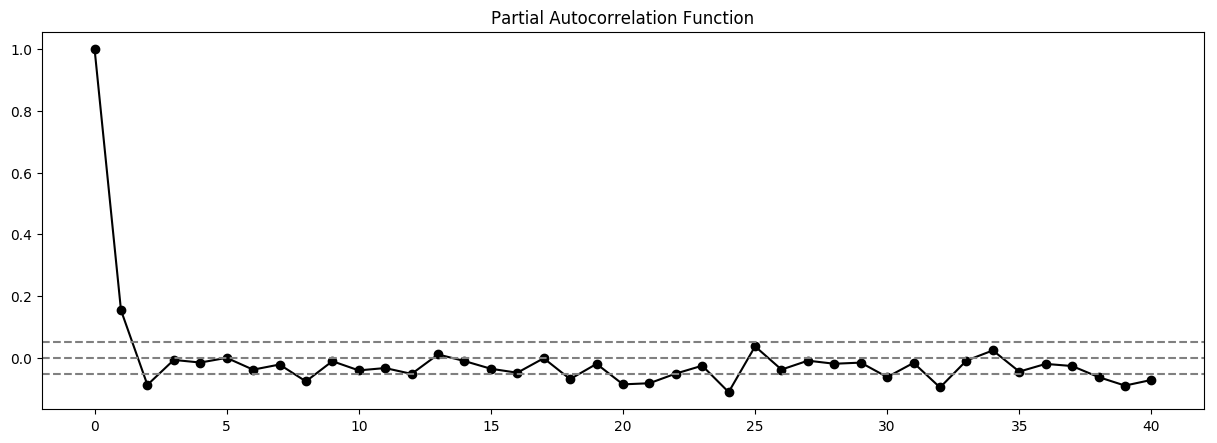

In [52]:
lag_pacf = pacf(prcp_res, nlags=40)

#Plot PACF: 
plt.plot(lag_pacf, 'ok-')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(prcp_res)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(prcp_res)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function');

__p=1__

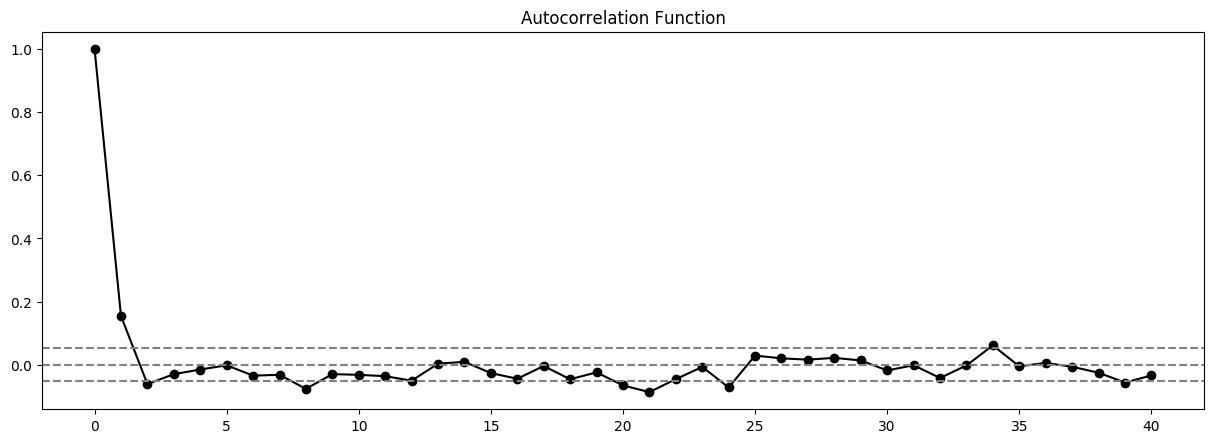

In [53]:
lag_acf = acf(prcp_res, nlags=40)

#Plot ACF: 
plt.plot(lag_acf, 'ok-')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(prcp_res)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(prcp_res)),linestyle='--',color='gray')
plt.title('Autocorrelation Function');

__q=1__

__Fitting model and predicting__

In [54]:
prcp_model = ARIMA(prcp_res, order=(1, 0, 1))
prcp_model_fit = prcp_model.fit(disp=-1)

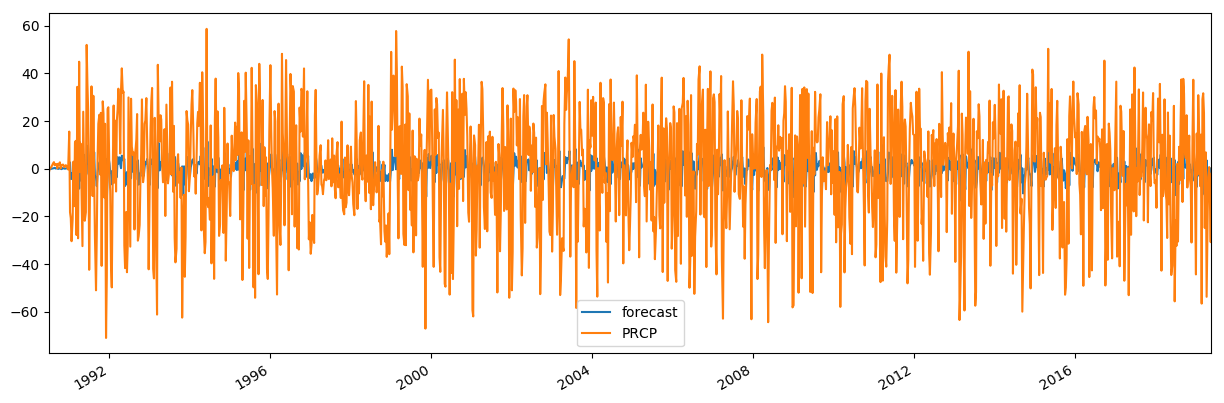

In [55]:
# Actual vs Fitted
prcp_model_fit.plot_predict(dynamic=False)
plt.show()

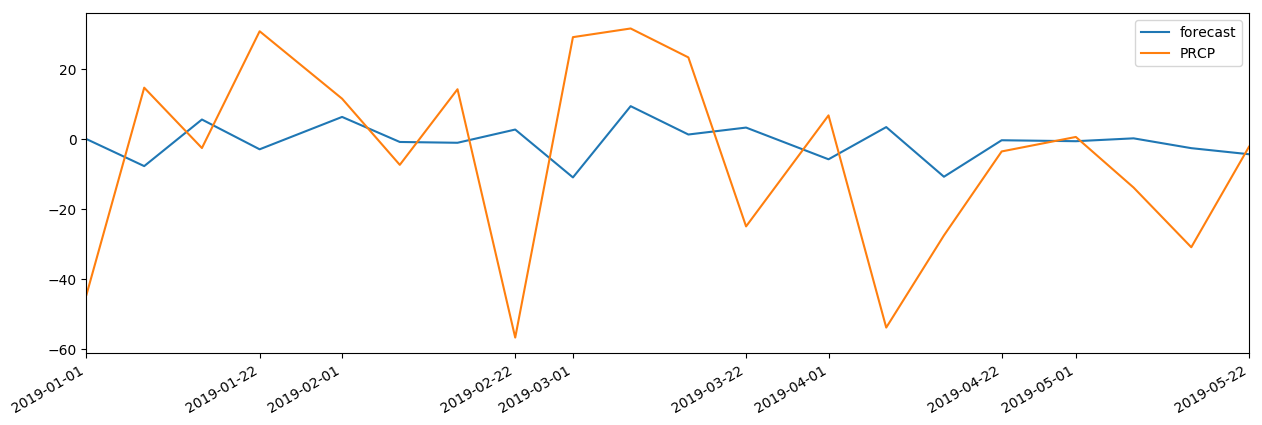

In [56]:
# only 2019 year
prcp_model_fit.plot_predict(start="2019-01-01"  ,dynamic=False)
plt.show()

# Results evaluation

Here, I'll demonstrate how much my prediction differce from real weather data.

In [59]:
from sklearn.metrics import mean_squared_error

def plot_results(original, model_fit, decom_results):
    
    forecast = model_fit.predict(start="2019-01-01")
    trend = decom_results[1].loc["2019-01-01":"2019-05-23",]
    season = decom_results[2].loc["2019-01-01":"2019-05-23",]
    
    predicted = forecast + trend + season
    
    months = sorted(list({str(date)[5:7] for date in original.index}))
    
    predicted_results, original_results = [], []
    
    for month in months:
        or_total, pred_total = 0, 0
        c = 0
        for indx in original.index:
            if str(indx)[5:7] == month:
                or_total += original[indx]
                pred_total += predicted[indx]
                c += 1
        predicted_results.append(pred_total / c)
        original_results.append(or_total / c)
        
    results = pd.DataFrame(data={'Real':original_results, 'Predicted':predicted_results}, 
                           index=months)
    
    print("RMSE:{}\n\n".format(mean_squared_error(original, predicted)**0.5))
                
    plt.plot(original)
    plt.plot(predicted)
    plt.legend(["Original", "Predicted"], loc='upper left')
    plt.show()
    
    
    return results

### Temperature

RMSE:3.209064177551157




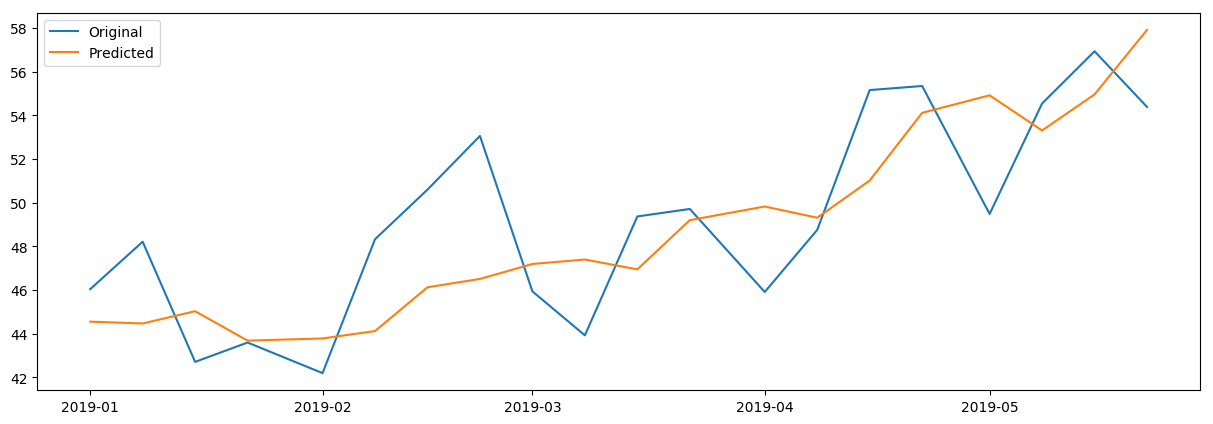

,Real,Predicted
01,45.142857,44.437529
02,48.546429,45.138311
03,47.239286,47.687105
04,51.292857,51.067842
05,53.836905,55.273173


In [60]:
plot_results(temp.loc["2019-01-01":"2019-05-23",], temp_model_fit, temp_results)

### Dew point

RMSE:3.1007401739495464




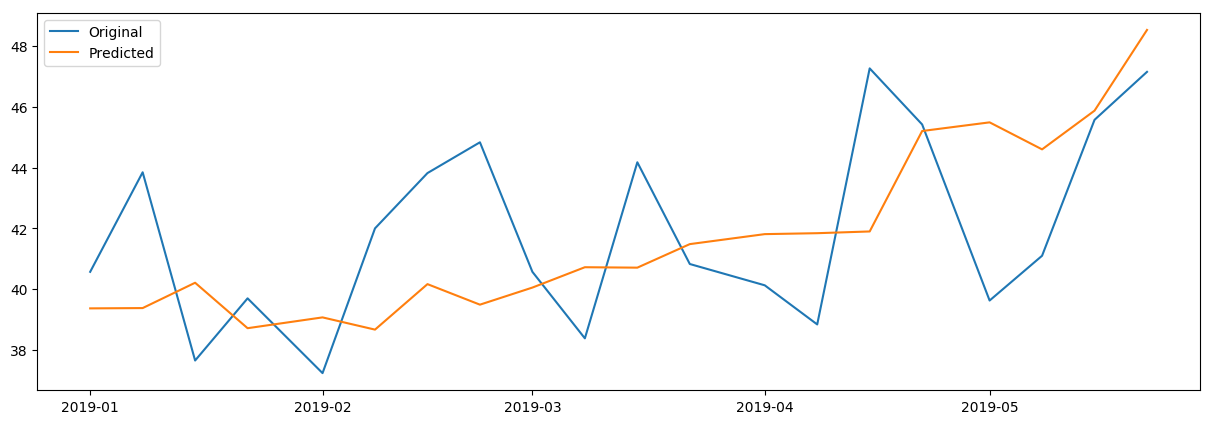

,Real,Predicted
01,40.442857,39.420734
02,41.972024,39.351722
03,40.989286,40.742006
04,42.910714,42.687216
05,43.359524,46.117102


In [61]:
plot_results(dewp.loc["2019-01-01":"2019-05-23",], dewp_model_fit, dewp_results)

### Visibility

RMSE:0.7009545305197761




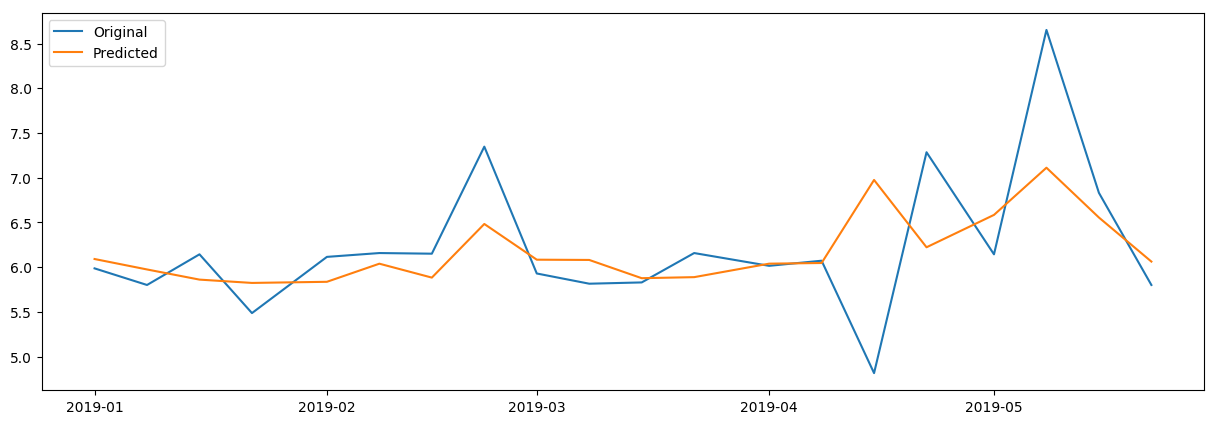

,Real,Predicted
01,5.853571,5.936769
02,6.442146,6.059621
03,5.932143,5.981611
04,6.046151,6.320128
05,6.856442,6.577900


In [64]:
plot_results(visib.loc["2019-01-01":"2019-05-23",], visib_model_fit, visib_results)

### Wind Speed

RMSE:2.015796826397987




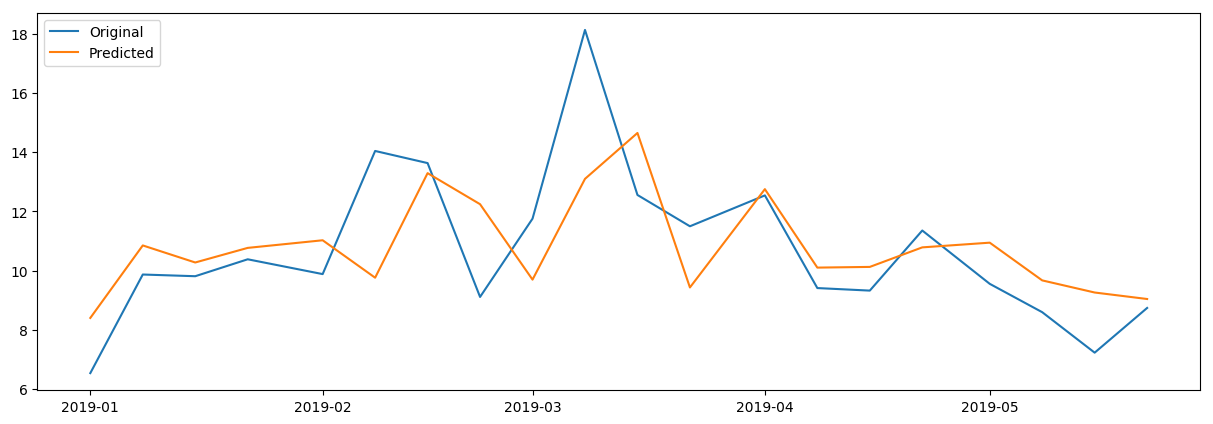

,Real,Predicted
01,9.153571,10.076856
02,11.669048,11.582802
03,13.485714,11.721309
04,10.660714,10.943671
05,8.533333,9.732299


In [65]:
plot_results(wdsp.loc["2019-01-01":"2019-05-23",], wdsp_model_fit, wdsp_results)

### Precipitation amount

RMSE:27.968187758851165




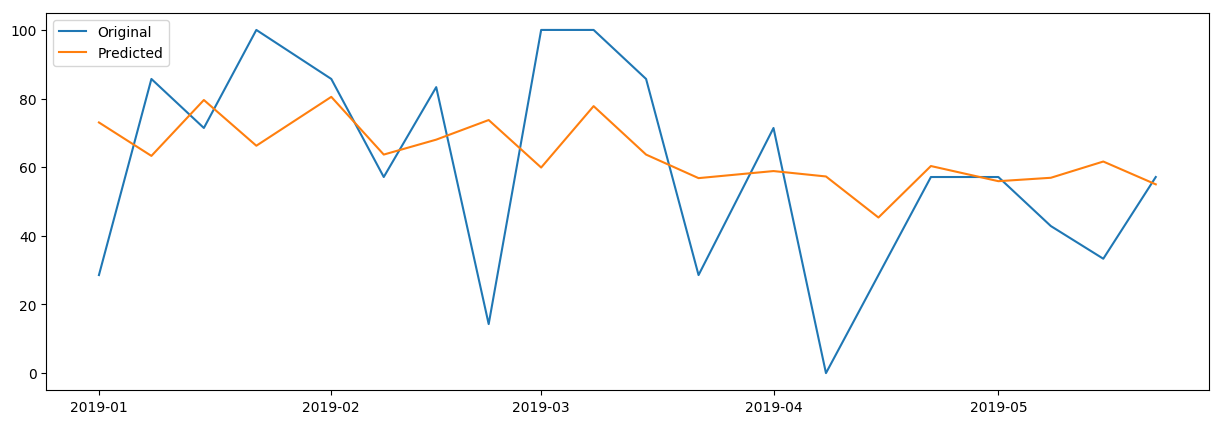

,Real,Predicted
01,71.421429,70.538094
02,60.113036,71.483618
03,78.563571,64.542372
04,39.281786,55.460493
05,47.614286,57.371677


In [66]:
plot_results(prcp.loc["2019-01-01":"2019-05-23",], prcp_model_fit, prcp_results)